In [1]:
import logging
import os
import pickle
import time
from functools import partial

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import arch, brax
from datasets import get_dataset
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from pathlib import Path
from PIL import Image

import jax
import jax.numpy as jnp
from jax import jit, vmap
from jax.example_libraries import optimizers, stax
from jax.tree_util import tree_map
from utils import get_calibration, jaxRNG

/nfs/home/sergioco/anaconda3/envs/jaxsde/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CIFAR10C(Dataset):
    def __init__(self, data_dir, transform=None, severity_level=3, selected_corruption=None):
        # Validate severity level
        if severity_level not in range(1, 6):
            raise ValueError("Severity level must be between 1 and 5.")

        # List all npy files (excluding labels.npy)
        all_data_files = sorted([f for f in Path(data_dir).glob('*.npy') if 'labels.npy' not in str(f)])
        
        # If a specific corruption type is specified, filter files for that corruption
        if selected_corruption is not None:
            self.data_files = [Path(data_dir) / f"{selected_corruption}.npy"]
        else:
            self.data_files = all_data_files

        self.labels = np.load(Path(data_dir) / 'labels.npy')
        self.transform = transform
        self.severity_level = severity_level
        
        # Each severity level has 10000 images for each corruption type
        self.images_per_level = 10000
        # Calculate the total number of images based on the selected corruption
        self.total_images = len(self.data_files) * self.images_per_level

    def __len__(self):
        # Return the total number of images in the dataset
        return self.total_images

    def __getitem__(self, idx):
        # Calculate which file and which image inside that file we want
        file_idx = idx // self.images_per_level  # Which file to access
        
        # Adjust index based on the severity level
        adjusted_idx = (self.severity_level - 1) * self.images_per_level + (idx % self.images_per_level)
        
        # Load the correct file based on the calculated file_idx
        data = np.load(self.data_files[file_idx])[adjusted_idx]
        
        # Load the corresponding label from the labels file
        label = self.labels[idx % self.images_per_level]  # Assuming labels are the same for all severity levels

        # Apply transformations if any
        if self.transform:
            data = self.transform(data)

        return data, label

class SuperimposedCIFAR10C(Dataset):
    def __init__(self, cifar10c_dataset, combine_same_class=True, alpha=0.5):
        """
        Initialize the dataset.

        Args:
        - cifar10c_dataset: Instance of CIFAR10C dataset.
        - combine_same_class: Boolean, True to combine images of the same class, False for different classes.
        - alpha: Float, transparency level for superimposing images.
        """
        self.cifar10c_dataset = cifar10c_dataset
        self.combine_same_class = combine_same_class
        self.alpha = alpha

    def __len__(self):
        return len(self.cifar10c_dataset)

    def __getitem__(self, idx):
        # Get the first image and its label
        img1, label1 = self.cifar10c_dataset[idx]

        if self.combine_same_class:
            # Find indices of the same class, excluding the current index
            same_class_indices = [i for i, t in enumerate(self.cifar10c_dataset.labels) if t == label1 and i != idx]
            other_idx = np.random.choice(same_class_indices)
        else:
            # Choose any other class, avoiding the current label
            different_class_indices = [i for i, t in enumerate(self.cifar10c_dataset.labels) if t != label1]
            other_idx = np.random.choice(different_class_indices)

        # Get the second image (it won't use its label)
        img2, _ = self.cifar10c_dataset[other_idx]

        # Convert numpy arrays to PIL images for blending
        img1 = transforms.ToPILImage()(img1)
        img2 = transforms.ToPILImage()(img2)

        # Superimpose images
        superimposed_img = Image.blend(img1, img2, alpha=self.alpha)

        # Apply any additional transformations defined in the original dataset
        if self.cifar10c_dataset.transform is not None:
            superimposed_img = self.cifar10c_dataset.transform(superimposed_img)

        return superimposed_img, label1

In [3]:
# Define all the 
model= 'psdebnn_h' #'psdebnn'
print("Using model:", model)
output='output-psde-horizontal-05'
seed=42
stl=False
lr=0.0007
epochs=100
bs=128
test_bs=1000
total_im = 10000 # Only for CIFAR-10-C
nsamples=1
w_init=-1.0
b_init=-1.0
p_init=-1.0
pause_every=200
no_drift=False
ou_dw=True
diff_coef=0.1
ds='cifar10c'
if ds == 'cifar10': ood=False
else: ood=True
severity_level = 2 # CHANGE ACCORDINGLY
alpha = 0.7 # CHANGE ACCORDINGLY
no_xt=True
acc_grad=1
aug=0
remat=False
ema=0.999
meanfield_sdebnn=False
infer_w0=False
w0_prior_std=0.1
disable_test=False
verbose=True
nblocks='2-2-2'
block_type=0
fx_dim=64
fx_actfn='softplus'
fw_dims='2-128-2'
fw_actfn='softplus'
lr_sched='constant'
rng_generator = jaxRNG(seed=seed)

# PSDEBNN specific
ode_first=False
timecut=0.5
if model == 'psdebnn': kl_coef=(1/(timecut))*10**-4
else: kl_coef=1e-3
fix_w1=False
method_ode='euler'

if ds == 'cifar10':
    print("Using CIFAR-10 dataset")
    train_loader, train_eval_loader, val_loader, test_loader, input_size, train_size = get_dataset(bs, test_bs, "cifar10")

    #indices = torch.randperm(len(test_loader.dataset)).tolist() # Check
    #test_subset_indices = indices[:test_bs]
    #test_subset = torch.utils.data.Subset(test_loader.dataset, test_subset_indices) # Check
    #test_loader = DataLoader(test_subset, batch_size=test_bs, shuffle=False)
    num_batches = len(test_loader)
    print(f"Number of test batches: {num_batches}")

elif ds == 'cifar10c' or ds == 'cifar10s':
    print("Using CIFAR-10-C dataset at severity level", severity_level)
    # Need to download manually from https://zenodo.org/records/2535967/files/CIFAR-10-C.tar?download=1
    input_size = (32, 32, 3)
    data_dir = "data/cifar10c"

    # Define your transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    cifar10c_dataset = CIFAR10C(data_dir=data_dir, transform=transform, severity_level=severity_level, selected_corruption=None)#"gaussian_noise")
    #print("Length of the dataset (raw): ", len(cifar10c_dataset))

    # Calculate the number of corruptions and images per corruption
    num_corruptions = len(cifar10c_dataset.data_files)
    images_per_corruption = total_im // num_corruptions

    # Generate indices for each corruption type
    indices = []
    for i in range(num_corruptions):
        start_idx = i * cifar10c_dataset.images_per_level
        end_idx = start_idx + images_per_corruption
        indices.extend(range(start_idx, end_idx))
    
    # Shuffle the indices to randomize the order
    random.shuffle(indices)
    # Create the subset and DataLoader
    test_subset = torch.utils.data.Subset(cifar10c_dataset, indices)

    if ds == 'cifar10s':
        print("Images are being superimposed with alpha =", alpha)
        # Create the superimposed dataset
        print("Combining images of the same class:", False)
        superimposed_dataset = SuperimposedCIFAR10C(test_subset, combine_same_class=False, alpha=alpha)

    test_loader = DataLoader(test_subset, batch_size=test_bs, shuffle=False)
    num_batches = len(test_loader)
    print(f"Number of test batches: {num_batches}")

elif ds == 'svhn':
    print("Using SVHN dataset")
    train_loader, train_eval_loader, val_loader, test_loader, input_size, train_size = get_dataset(bs, test_bs, "svhn")

    indices = torch.randperm(len(test_loader.dataset)).tolist()
    test_subset_indices = indices[:test_bs]
    test_subset = torch.utils.data.Subset(test_loader.dataset, test_subset_indices)
    test_loader = DataLoader(test_subset, batch_size=int(test_bs/10), shuffle=False)
    num_batches = len(test_loader)
    print(f"Number of test batches: {num_batches}")
    
else:
    raise ValueError("Dataset not supported!")
    
# SDEBNN specific
mf = partial(brax.MeanField, disable=True) if kl_coef == 0. else brax.MeanField
fw_dims = list(map(int, fw_dims.split("-")))
layers = [mf(arch.Augment( aug))]
nblocks = list(map(int, nblocks.split("-")))
opt_init, opt_update, get_params = optimizers.adam(7e-4)

# Load the checkpoint if it exists
checkpoint_path = os.path.join(output, 'best_model_checkpoint.pkl')
if os.path.exists(checkpoint_path):
    logging.warning("Loading checkpoints...")
    with open(checkpoint_path, "rb") as f:
        checkpoint = pickle.load(f)

    # Extract states from the checkpoint
    start_epoch = checkpoint['epoch']
    best_val_acc = checkpoint['best_val_acc']
    global_step = checkpoint['global_step']
    opt_state = checkpoint['optimizer_state']
    ema_params = checkpoint['ema_state']
    params = checkpoint['model_state']  # Loaded parameters
    print(f"Successfully loaded checkpoints for epoch {start_epoch} with best validation accuracy {best_val_acc}")
else:
    raise SystemExit("No checkpoint found!")

Using model: psdebnn_h


Using CIFAR-10-C dataset at severity level 2
Number of test batches: 10
Successfully loaded checkpoints for epoch 98 with best validation accuracy 0.8724000453948975


In [4]:
print(len(test_loader.dataset))
print(len(test_loader))

9994
10


In [5]:
def _nll(params, batch, rng):
    inputs, targets = batch
    preds, kl, info_dict = _predict(params, inputs, rng=rng, full_output=False)
    nll = -jnp.mean(jnp.sum(preds * targets, axis=1))
    return preds, nll, kl, info_dict


@partial(jit, static_argnums=(3,))
def sep_loss(params, batch, rng, kl_coef):  # no backprop
    preds, nll, kl, _ = _nll(params, batch, rng)
    if kl_coef > 0:
        obj_loss = nll + kl * kl_coef
    else:
        obj_loss = nll
    _sep_loss = {'loss': obj_loss, 'kl': kl, 'nll': nll, 'preds': preds}
    return obj_loss, _sep_loss

@partial(jit, static_argnums=(3,))
def loss(params, batch, rng, kl_coef):  # backprop so checkpoint
    _, nll, kl, _ = jax.checkpoint(_nll)(params, batch, rng)
    if kl_coef > 0:
        return nll + kl * kl_coef
    else:
        return nll

@jit
def predict(params, inputs, rng): 
    return _predict(params, inputs, rng=rng, full_output=True)

@partial(jit, static_argnums=(2,))
def accuracy(params, data, nsamples, rng):
    inputs, targets = data
    target_class = jnp.argmax(targets, axis=1)
    rngs = jax.random.split(rng, nsamples)
    preds, _, info_dic = vmap(predict, in_axes=(None, None, 0))(params, inputs, rngs)
    preds = jnp.stack(preds, axis=0)
    avg_preds = preds.mean(0)
    predicted_class = jnp.argmax(avg_preds, axis=1)
    n_correct = jnp.sum(predicted_class == target_class)
    n_total = inputs.shape[0]
    wts = info_dic[model+'_w'] 
    wts = jnp.stack(wts, axis=0)
    avg_wts = wts.mean(0)
    return n_correct, n_total, avg_preds, avg_wts

def update_ema(ema_params, params, momentum=0.999):
    return tree_map(lambda e, p: e * momentum + p * (1 - momentum), ema_params, params)

def evaluate(params, data_loader, input_size, nsamples, rng_generator, kl_coef):
    n_total = 0
    n_correct = 0
    nll = 0
    kl = 0
    logits = np.array([])
    wts = np.array([])
    labels = np.array([])
    for inputs, targets in data_loader:
        targets = jax.nn.one_hot(jnp.array(targets), num_classes=10)
        inputs = jnp.array(inputs).reshape((-1,) + (input_size[-1],) + input_size[:2])
        inputs = jnp.transpose(inputs, (0, 2, 3, 1))  # Permute from NCHW to NHWC
        batch_correct, batch_total, _logits, _wts = accuracy(
            params, (inputs, targets), nsamples, rng_generator.next()
        )
        n_correct = n_correct + batch_correct
        _, batch_nll, batch_kl, _ = jit(_nll)(params, (inputs, targets), rng_generator.next())
        if n_total == 0:
            logits = np.array(_logits)
            wts = np.array(_wts)
            labels = np.array(targets)
        else:
            logits = np.concatenate([logits, np.array(_logits)], axis=0)
            wts = np.concatenate([wts, np.array(_wts)], axis=0)
            labels = np.concatenate([labels, targets], axis=0)
        n_total = n_total + batch_total
        nll = nll + batch_nll
        kl = kl + batch_kl
    return n_correct / n_total, jnp.stack(logits, axis=0), labels, nll / n_total, kl / n_total, jnp.stack(wts, axis=0)

nsteps = 30 # CHANGE FOR EACH EXPERIMENT

if ood:
    print("Starting OOD experiment with dataset:", ds)
else:
    print("Starting ID experiment")

if model == "sdebnn":
    for i, nb in enumerate(nblocks):
        fw = arch.MLP(fw_dims, actfn=fw_actfn, xt=no_xt, ou_dw=ou_dw, nonzero_w=w_init, nonzero_b=b_init, p_scale=p_init)  # weight network is time dependent
        if meanfield_sdebnn:
            layers.extend([mf(brax.SDEBNN(block_type,
                                            fx_dim,
                                            fx_actfn,
                                            fw,
                                            diff_coef=diff_coef,
                                            stl=stl,
                                            xt=no_xt,
                                            nsteps=nsteps,
                                            remat=remat,
                                            w_drift=not no_drift,
                                            stax_api=True,
                                            infer_initial_state=infer_w0,
                                            initial_state_prior_std=w0_prior_std)) for _ in range(nb)
            ])
        else:
            layers.extend([brax.SDEBNN( block_type,
                                        fx_dim,
                                        fx_actfn,
                                        fw,
                                        diff_coef=diff_coef,
                                        stl=stl,
                                        xt=no_xt,
                                        nsteps=nsteps,
                                        remat=remat,
                                        w_drift=not no_drift,
                                        infer_initial_state=infer_w0,
                                        initial_state_prior_std=w0_prior_std) for _ in range(nb)
            ])
        if i < len(nblocks) - 1:
            layers.append(mf(arch.SqueezeDownsample(2)))
    layers.append(mf(stax.serial(stax.Flatten, stax.Dense(10), stax.LogSoftmax)))

    init_random_params, _predict = brax.bnn_serial(*layers)

elif model == "psdebnn":
    for i, nb in enumerate(nblocks):
        fw = arch.MLP(fw_dims, actfn=fw_actfn, xt=no_xt, ou_dw=ou_dw, nonzero_w=w_init, nonzero_b=b_init, p_scale=p_init)  # weight network is time dependent
        if meanfield_sdebnn:
            layers.extend([mf(brax.PSDEBNN( block_type,
                                            fx_dim,
                                            fx_actfn,
                                            fw,
                                            diff_coef=diff_coef,
                                            stl=stl,
                                            xt=no_xt,
                                            nsteps=nsteps,
                                            remat=remat,
                                            w_drift=not no_drift,
                                            stax_api=True,
                                            infer_initial_state=infer_w0,
                                            initial_state_prior_std=w0_prior_std,
                                            ode_first=ode_first,
                                            timecut=timecut,
                                            method_ode=method_ode,
                                            fix_w1=fix_w1)) for _ in range(nb)
            ])
        else:
            layers.extend([brax.PSDEBNN(block_type,
                                        fx_dim,
                                        fx_actfn,
                                        fw,
                                        diff_coef=diff_coef,
                                        stl=stl,
                                        xt=no_xt,
                                        nsteps=nsteps,
                                        remat=remat,
                                        w_drift=not no_drift,
                                        infer_initial_state=infer_w0,
                                        initial_state_prior_std=w0_prior_std,
                                        ode_first=ode_first,
                                        timecut=timecut,
                                        method_ode=method_ode,
                                        fix_w1=fix_w1) for _ in range(nb)
            ])
        if i < len(nblocks) - 1:
            layers.append(mf(arch.SqueezeDownsample(2)))
    layers.append(mf(stax.serial(stax.Flatten, stax.Dense(10), stax.LogSoftmax)))

    init_random_params, _predict = brax.bnn_serial(*layers)

else:
    # PSDEBNN_H
    for i, nb in enumerate(nblocks):
        fw_s = arch.MLP(fw_dims, actfn=fw_actfn, xt=no_xt, ou_dw=ou_dw, nonzero_w=w_init, nonzero_b=b_init, p_scale=p_init)  # Stochastic weights
        fw_d = arch.MLP(fw_dims, actfn=fw_actfn, xt=no_xt, ou_dw=ou_dw, nonzero_w=w_init, nonzero_b=b_init, p_scale=p_init)  # Deterministic weights
        if meanfield_sdebnn:
            layers.extend([mf(brax.PSDEBNN_H(block_type,
                                            fx_dim,
                                            fx_actfn,
                                            fw1=fw_s,
                                            fw2=fw_d,
                                            ratio=timecut,
                                            diff_coef=diff_coef,
                                            stl=stl,
                                            xt=no_xt,
                                            nsteps=nsteps,
                                            remat=remat,
                                            w_drift=not no_drift,
                                            stax_api=True,
                                            infer_initial_state=infer_w0,
                                            initial_state_prior_std=w0_prior_std)) for _ in range(nb)
            ])
        else:
            layers.extend([brax.PSDEBNN_H(block_type,
                                        fx_dim,
                                        fx_actfn,
                                        fw1=fw_s,
                                        fw2=fw_d,
                                        ratio=timecut,
                                        diff_coef=diff_coef,
                                        stl=stl,
                                        xt=no_xt,
                                        nsteps=nsteps,
                                        remat=remat,
                                        w_drift=not no_drift,
                                        infer_initial_state=infer_w0,
                                        initial_state_prior_std=w0_prior_std) for _ in range(nb)
            ])
        if i < len(nblocks) - 1:
            layers.append(mf(arch.SqueezeDownsample(2)))
    layers.append(mf(stax.serial(stax.Flatten, stax.Dense(10), stax.LogSoftmax)))

    init_random_params, _predict = brax.bnn_serial(*layers)

# for inputs, targets in tqdm(test_loader): # evaluate already deals with the loop
start_time = time.time()
acc, logits, targets, nll, _, _ = evaluate(params, test_loader, input_size, nsamples, rng_generator, kl_coef=kl_coef)

# Calculate inference time
inference_time = time.time() - start_time

# Convert logits to probabilities
if ood:
    probabilities_ood = jax.nn.softmax(logits)
    # TODO: might be better to use utils.ECE or utils.compute_acc_bin
    cal = get_calibration(targets, probabilities_ood)
else:
    probabilities_id = jax.nn.softmax(logits) # probabilities_ood when ood data is used
    # TODO: might be better to use utils.ECE or utils.compute_acc_bin
    cal = get_calibration(targets, probabilities_id)

print(f"Inference time with {nsteps} steps: {inference_time} (s)")
print(f"Accuracy with {nsteps} steps: {acc}")
print(f"NLL with {nsteps} steps: {nll}")
print(f"ECE with {nsteps} steps: {cal['ece']}")

print("Experiment run sucessfully!")

Starting OOD experiment with dataset: cifar10c
there were [   0.    0.   29.  195.  501.  758.  686.  796. 1070. 5819.] items in bins 1-10
Inference time with 30 steps: 303.06504797935486 (s)
Accuracy with 30 steps: 0.7346407771110535
NLL with 30 steps: 0.0009109735256060958
ECE with 30 steps: 0.12179474224026395
Experiment run sucessfully!


### OOD Detection

Scores shape: (11000,)
Scores shape after removing NaN values: (11000,)


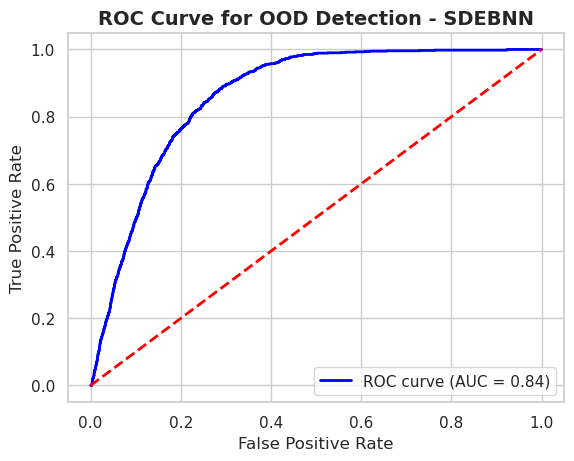

In [65]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import torch

# Using entropy as confidence scores
def entropy(probs):
    return -torch.sum(probs * torch.log(probs), dim=1)

# Create PyTorch tensors directly from NumPy arrays
probabilities_id_np = np.array(probabilities_id)
probabilities_id_torch = torch.tensor(probabilities_id_np)

probabilities_ood_np = np.array(probabilities_ood)
probabilities_ood_torch = torch.tensor(probabilities_ood_np)

id_probs_entropy = entropy(probabilities_id_torch)
ood_probs_entropy = entropy(probabilities_ood_torch)

# Combine ID and OOD entropy scores
scores = torch.cat([id_probs_entropy, ood_probs_entropy]).numpy()
labels = np.concatenate([np.zeros(len(id_probs_entropy)), np.ones(len(ood_probs_entropy))])

print(f"Scores shape: {scores.shape}")

# Find the indices of NaN values in the scores array
nan_indices = np.isnan(scores)

# Remove NaN values from both scores and labels arrays
scores = scores[~nan_indices]
labels = labels[~nan_indices]

print(f"Scores shape after removing NaN values: {scores.shape}")

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, scores)
auc = roc_auc_score(labels, scores)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for OOD Detection - SDEBNN', fontweight='bold', fontsize=14)
plt.legend(loc="lower right")
plt.savefig('experiments/roc_curves/rc_SDEBNN.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Predictive Entropy Analysis

Number of high uncertainty predictions: 1261
Number of low uncertainty predictions: 8733
Mean entropy: 0.39358747005462646 and std entropy: 0.43557611107826233


/nfs/home/sergioco/anaconda3/envs/jaxsde/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


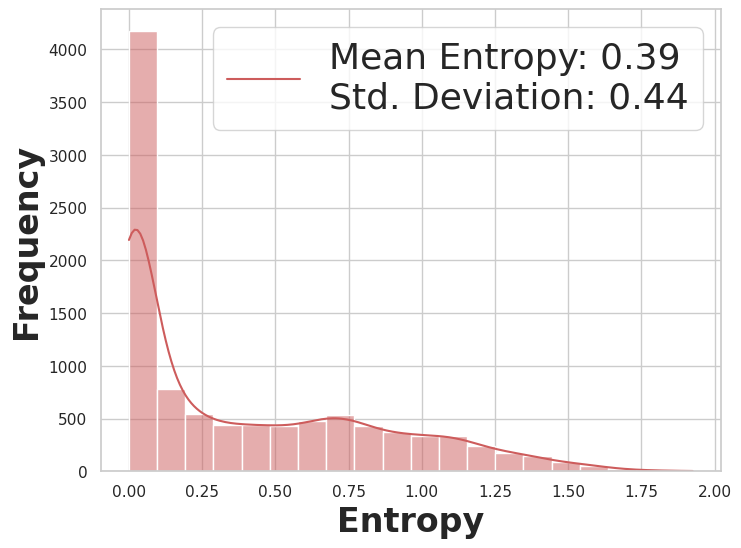

In [6]:
"""
- Compare with Ground Truth: If possible, compare entropy values with the ground truth to see if higher entropy correlates with incorrect predictions.
- Correlation Analysis: Look for correlations between entropy and other factors, e.g. difficulty of examples, to understand in what situations the models are more uncertain.

WHAT WE EXPECT:
1. Well-calibrated Model: A model with good uncertainty calibration will have a wide range of entropy values, with higher entropy corresponding to less certain predictions.
2. Overconfident Model: If a model is overconfident, you'll see a distribution skewed towards lower entropy values, even for incorrect predictions.
3. Underconfident Model: Conversely, an underconfident model will have a distribution skewed towards higher entropy values, indicating uncertainty even in correct predictions.
4. Partially vs. Fully Stochastic: The partially stochastic model might show a tighter distribution if it's better at distinguishing clear cases, while the fully stochastic model might exhibit higher entropy overall, reflecting greater inherent uncertainty.

The key is to see if higher entropy aligns with instances where the model should be uncertain (e.g., incorrect predictions, OOD data) and lower entropy aligns with correct and confident predictions.
"""
if ood:
    probabilities_np = np.array(probabilities_ood)
else:
    probabilities_np = np.array(probabilities_id)
probabilities_torch = torch.tensor(probabilities_np)

entropy = -torch.sum(probabilities_torch * torch.log(probabilities_torch), dim=1)

# Find the indices of NaN values in the scores array
nan_indices = np.isnan(entropy.numpy())
# Remove NaN values from both scores and labels arrays
entropy = entropy[~nan_indices]

mean_entropy = torch.mean(entropy) # Should be high for OOD data
std_entropy = torch.std(entropy)

uncertainty_threshold = 1.
# Classify predictions
high_uncertainty_predictions = entropy.numpy() > uncertainty_threshold
low_uncertainty_predictions = entropy.numpy() <= uncertainty_threshold
print(f"Number of high uncertainty predictions: {np.sum(high_uncertainty_predictions)}")
print(f"Number of low uncertainty predictions: {np.sum(low_uncertainty_predictions)}")

print(f"Mean entropy: {mean_entropy} and std entropy: {std_entropy}")
# Set Seaborn style
sns.set(style="whitegrid")

# Create a histogram plot
plt.figure(figsize=(8, 6))
sns.histplot(entropy.numpy(), bins=20, kde=True, color='indianred') # indianred, royalblue, springgreen

# Add labels and title
plt.xlabel('Entropy', fontsize=24, fontweight='bold')
plt.ylabel('Frequency', fontsize=24, fontweight='bold')
plt.legend([f'Mean Entropy: {mean_entropy:.2f}\nStd. Deviation: {std_entropy:.2f}'], fontsize=26, loc='upper right')
#plt.savefig('experiments/entropy_analysis/entropy_sdefirst_01_OOD.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

**ODEFirst**
Corruption 2:
Mean entropy: 0.32254835963249207 and std entropy: 0.4092399477958679

Corruption 3:
Mean entropy: 0.3805495798587799 and std entropy: 0.43113023042678833

Corruption 4:
Mean entropy: 0.43136927485466003 and std entropy: 0.4496398866176605

Corruption 5:
Mean entropy: 0.5027499198913574 and std entropy: 0.4653160274028778

Same class superimposed images:

alpha = 0.1:
Mean entropy: 0.267250657081604 and std entropy: 0.3804560601711273

alpha = 0.5:
Mean entropy: 0.2672593891620636 and std entropy: 0.3799605965614319

alpha = 0.7
Mean entropy: 0.26785144209861755 and std entropy: 0.3809540867805481

Different class superimposed images:

alpha = 0.1:
Mean entropy: 0.257 and std entropy: 0.377

alpha = 0.3:
Mean entropy: 0.267 and std entropy: 0.421

alpha = 0.5:
Mean entropy: 0.26815086603164673 and std entropy: 0.38195163011550903

alpha = 0.7:
Mean entropy: 0.263 and std entropy: 0.390

**SDEFirst**
Corruption 2:
Mean entropy: 0.44311216473579407 and std entropy: 0.4676474928855896

Corruption 3:
Mean entropy: 0.4977395534515381 and std entropy: 0.4804195463657379

Corruption 4:
Mean entropy: 0.5425954461097717 and std entropy: 0.4885020852088928

Corruption 5:
Mean entropy: 0.6280019879341125 and std entropy: 0.5118327736854553

Same class superimposed images:

alpha = 0.5:
Mean entropy: 0.3845650553703308 and std entropy: 0.4502585530281067

Different class superimposed images:

alpha = 0.1:
Mean entropy: 0.3724273943901062 and std entropy: 0.4493037462234497

alpha = 0.3:
Mean entropy: 0.38032725858688354 and std entropy: 0.44813477993011475

alpha = 0.5:
Mean entropy: 0.382662202835083 and std entropy: 0.4471930265426636

alpha = 0.7:
Mean entropy: 0.3788013160228729 and std entropy: 0.44448432326316833

**SDEBNN**
Corruption 2:
Mean entropy: 0.2558216452598572 and std entropy: 0.3525136411190033

Corruption 3:
Mean entropy: 0.29258766770362854 and std entropy: 0.37010127305984497

Corruption 4:
Mean entropy: 0.33264872431755066 and std entropy: 0.3884868323802948

Corruption 5:
Mean entropy: 0.3749643862247467 and std entropy: 0.4054364562034607

Same class superimposed images:

alpha = 0.5:
Mean entropy: 0.20377382636070251 and std entropy: 0.3206897974014282

Different class superimposed images:

alpha = 0.1:
Mean entropy: 0.19973111152648926 and std entropy: 0.3188120424747467

alpha = 0.3:
Mean entropy: 0.20145323872566223 and std entropy: 0.319506973028183

alpha = 0.5:
Mean entropy: 0.19967612624168396 and std entropy: 0.318182110786438

alpha = 0.7:
Mean entropy: 0.20139466226100922 and std entropy: 0.3194402754306793

**Horizontal Cut**
Corruption 2:
Mean entropy: 0.39358747005462646 and std entropy: 0.43557611107826233

Corruption 3:
Mean entropy: 0.42914859533309937 and std entropy: 0.4467945694923401

Corruption 4:
Mean entropy: 0.487521767616272 and std entropy: 0.45213156938552856

Corruption 5:
Mean entropy: 0.5405126214027405 and std entropy: 0.4576523005962372

Different class superimposed images:

alpha = 0.1:
Mean entropy: 0.3175649642944336 and std entropy: 0.4042709469795227

alpha = 0.3:
Mean entropy: 0.31968405842781067 and std entropy: 0.4068707823753357

alpha = 0.5:
Mean entropy: 0.3189587891101837 and std entropy: 0.40494304895401

alpha = 0.7:
Mean entropy: 0.3171311616897583 and std entropy: 0.4043164849281311

torch.Size([3, 32, 32])


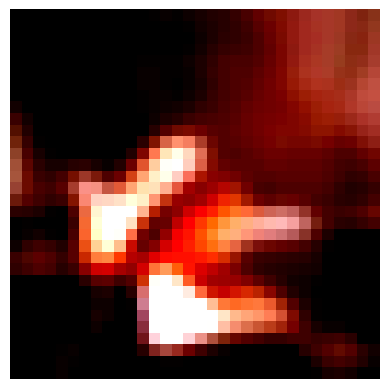

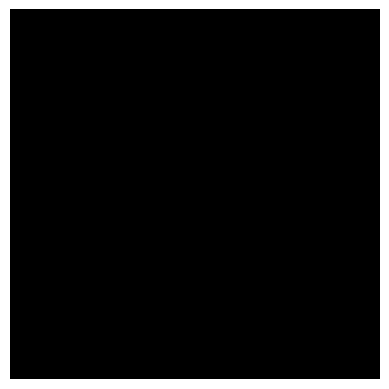

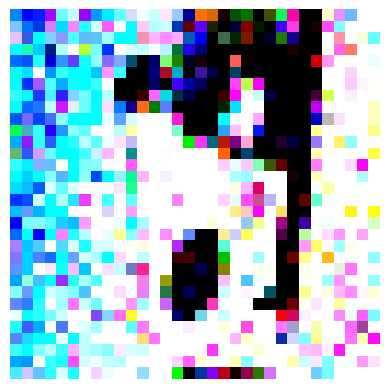

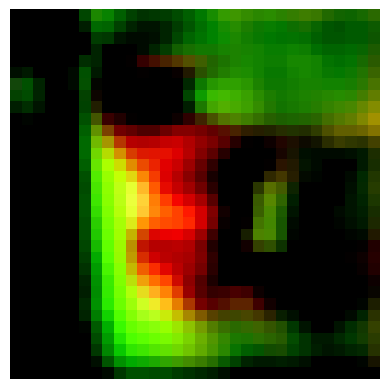

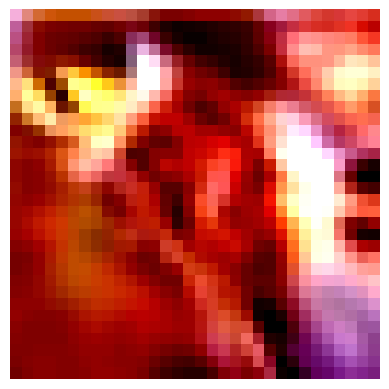

In [114]:
print(test_loader.dataset[0][0].shape)
for i in range(5):
    plt.imshow(test_loader.dataset[i][0].T)
    plt.axis("off")
    plt.show()

In [15]:
ood=True

SDEFirst (t=0.1):
ID Experiment:
Number of high uncertainty predictions: 549
Number of low uncertainty predictions: 4451
Mean entropy: 0.32678788900375366 and std entropy: 0.4287969470024109

OOD Experiment:
Number of high uncertainty predictions: 2710
Number of low uncertainty predictions: 2290
Mean entropy: 1.0001659393310547 and std entropy: 0.37521806359291077

ODEFirst (t=0.1):
ID Experiment:
Number of high uncertainty predictions: 276
Number of low uncertainty predictions: 4724
Mean entropy: 0.21221035718917847 and std entropy: 0.34835919737815857

OOD Experiment:
Number of high uncertainty predictions: 1339
Number of low uncertainty predictions: 3661
Mean entropy: 0.7546650767326355 and std entropy: 0.364822119474411

SDEBNN:
ID Experiment:
Number of high uncertainty predictions: 133
Number of low uncertainty predictions: 4861
Mean entropy: 0.1565878689289093 and std entropy: 0.28682979941368103

OOD Experiment:
Number of high uncertainty predictions: 707
Number of low uncertainty predictions: 4293
Mean entropy: 0.5507951378822327 and std entropy: 0.37698736786842346

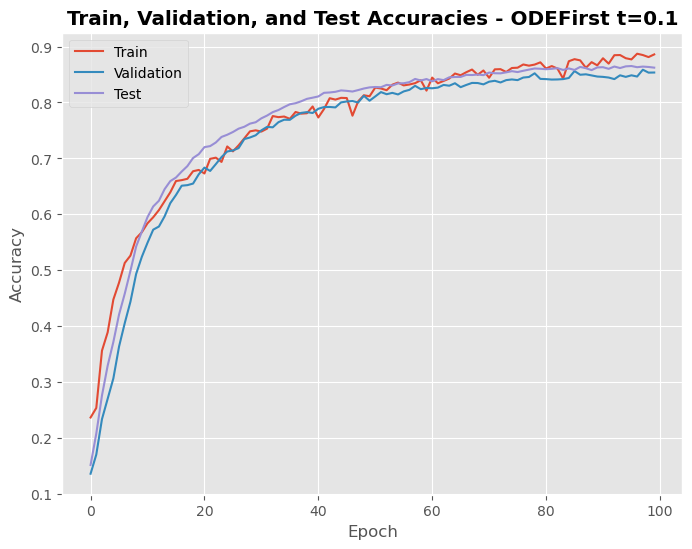

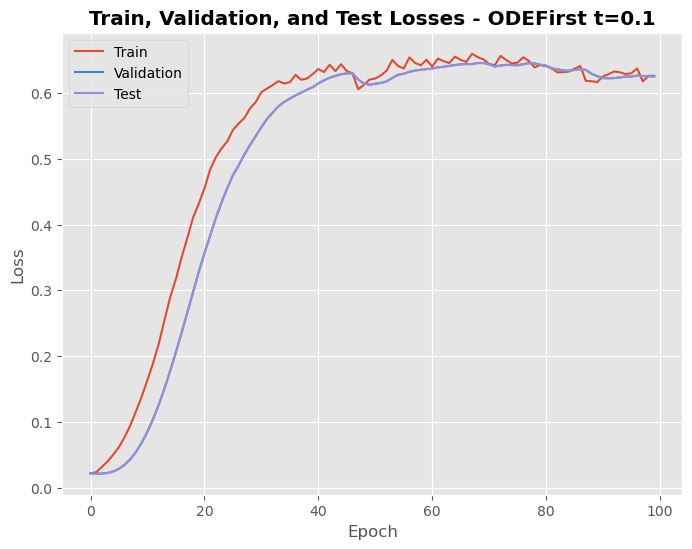

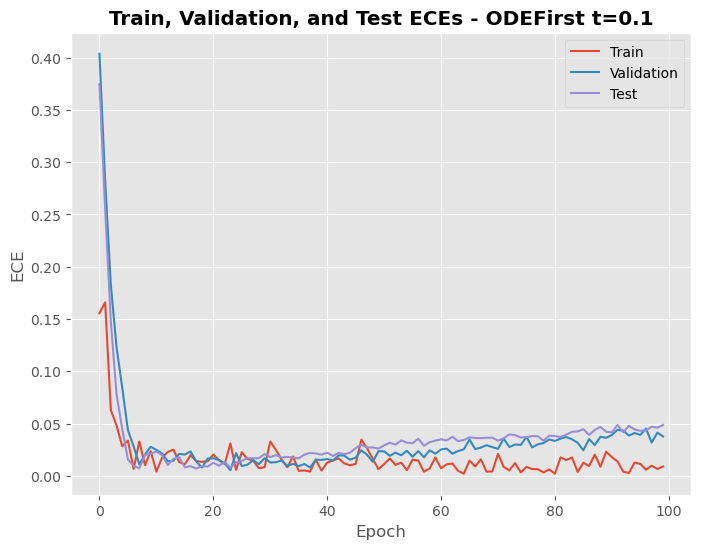

('Average time per epoch for output-psde-horizontal-07/results.txt:',
 319.29339999999996)

In [4]:
import re
import numpy as np
import matplotlib.pyplot as plt

file_path = 'output-psde-horizontal-07/results.txt'

# Open the file and read its contents
with open(file_path, 'r') as file:
    contents = file.readlines()

# Output the first few lines to get a sense of the data structure
contents[:10]  # Display the first 10 lines for brevity

# Parse the contents and extract data
epoch_times = []
train_accuracies = []
val_accuracies = []
test_accuracies = []
train_losses = []
val_losses = []
test_losses = []
train_ECEs = []
val_ECEs = []
test_ECEs = []

# Regular expression pattern for extracting data
pattern = r'Epoch (\d+) in ([\d.]+) sec \| Train acc ([\d.]+) \| Val acc ([\d.]+) \| Test acc ([\d.]+) \| Train loss ([\d.e+-]+) \| Val loss ([\d.e+-]+) \| Test loss ([\d.e+-]+) \| Train KL [\d.e+-]+ \| Val KL [\d.e+-]+ \| Test KL [\d.e+-]+ \| Train ECE ([\d.e+-]+) \| Val ECE ([\d.e+-]+) \| Test ECE ([\d.e+-]+)'

# Extract data using regex
for line in contents:
    match = re.search(pattern, line)
    if match:
        epoch_times.append(float(match.group(2)))
        train_accuracies.append(float(match.group(3)))
        val_accuracies.append(float(match.group(4)))
        test_accuracies.append(float(match.group(5)))
        train_losses.append(float(match.group(6)))
        val_losses.append(float(match.group(7)))
        test_losses.append(float(match.group(8)))
        train_ECEs.append(float(match.group(9)))
        val_ECEs.append(float(match.group(10)))
        test_ECEs.append(float(match.group(11)))

# Compute average time per epoch
average_time_per_epoch = np.mean(epoch_times)

# Now let's create the visualizations
# Set the style for the plots
plt.style.use('ggplot')

# Function to create a plot
def create_plot(y_values, y_label, title, file_name):
    plt.figure(figsize=(8, 6))
    plt.plot(y_values[0], label='Train')
    plt.plot(y_values[1], label='Validation')
    plt.plot(y_values[2], label='Test')
    plt.xlabel('Epoch')
    plt.ylabel(y_label)
    plt.title(title, fontweight='bold')
    plt.legend()
    plt.savefig(f'experiments/train_curves/{file_name}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# 2. The progress of the train, validation, and test accuracies
create_plot([train_accuracies[:100], val_accuracies[:100], test_accuracies[:100]], 'Accuracy', 'Train, Validation, and Test Accuracies - ODEFirst t=0.1', file_name='acc_odefirst_01')

# 3. The progress of the train, validation, and test losses
create_plot([train_losses, val_losses, test_losses], 'Loss', 'Train, Validation, and Test Losses - ODEFirst t=0.1', file_name='loss_odefirst_01')

# 4. The progress of the train, validation, and test ECEs
create_plot([train_ECEs, val_ECEs, test_ECEs], 'ECE', 'Train, Validation, and Test ECEs - ODEFirst t=0.1', file_name='ece_odefirst_01')

f"Average time per epoch for {file_path}:", average_time_per_epoch

### LL Laplacian Approx (ResNet)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import torch.distributions as dists
from laplace import Laplace
import numpy as np

# Set seeds for reproducibility
torch.manual_seed(7777)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Load CIFAR-10 datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained model and move it to the device (CUDA if available)
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model = model.to(device)
model.eval()

# Fit the Laplace approximation
la = Laplace(model, 'classification', subset_of_weights='last_layer', hessian_structure='kron')
la.fit(trainloader)
la.optimize_prior_precision(method='marglik')

@torch.no_grad()
def predict(dataloader, model, laplace=False):
    py = []

    for x, _ in dataloader:
        x = x.to(device)  # Move input data to the same device as the model
        if laplace:
            py.append(model(x))
        else:
            py.append(torch.softmax(model(x), dim=-1))

    return torch.cat(py).cpu()

# Predictions using the model with and without Laplace approximation
probs_map = predict(testloader, model, laplace=False)
probs_laplace = predict(testloader, la, laplace=True)

# Calculate accuracy, ECE, and NLL for MAP and Laplace
targets = torch.cat([y for _, y in testloader], dim=0).numpy()
# Convert targets to a torch tensor if it's not already
targets = torch.tensor(targets)

# Calculate accuracy for MAP
predictions_map = probs_map.argmax(-1)
correct_map = predictions_map.eq(targets).sum().item()
acc_map = correct_map / targets.size(0)

# Calculate accuracy for Laplace
predictions_laplace = probs_laplace.argmax(-1)
correct_laplace = predictions_laplace.eq(targets).sum().item()
acc_laplace = correct_laplace / targets.size(0)

print(f'[MAP] Accuracy: {acc_map:.2f}')
print(f'[Laplace] Accuracy: {acc_laplace:.2f}')

In [ ]:
from netcal.metrics import ECE

# ECE computation
ece_metric = ECE(bins=50)

# Convert the probabilities and targets to numpy for ECE calculation
probs_map_np = probs_map.numpy()
probs_laplace_np = probs_laplace.numpy()
targets_np = targets.numpy()

# ECE for MAP
ece_map = ece_metric.measure(probs_map_np, targets_np)

# ECE for Laplace
ece_laplace = ece_metric.measure(probs_laplace_np, targets_np)

print(f'[MAP] Accuracy: {acc_map:.6f}, ECE: {ece_map:.6f}')
print(f'[Laplace] Accuracy: {acc_laplace:.6f}, ECE: {ece_laplace:.6f}')

### Resize PDFs

In [ ]:
import os
from PyPDF2 import PdfReader, PdfWriter

def get_smallest_dimensions(folder_path):
    smallest_width = float('inf')
    smallest_height = float('inf')
    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            with open(os.path.join(folder_path, filename), 'rb') as f:
                reader = PdfReader(f)
                for page in reader.pages:
                    width = int(page.mediabox.width)
                    height = int(page.mediabox.height)
                    smallest_width = min(smallest_width, width)
                    smallest_height = min(smallest_height, height)
    return smallest_width, smallest_height

def resize_pdf(pdf_path, new_width, new_height):
    with open(pdf_path, 'rb') as f:
        reader = PdfReader(f)
        writer = PdfWriter()

        for page in reader.pages:
            page.scale_to(new_width, new_height)
            writer.add_page(page)

        with open(pdf_path, 'wb') as output_f:
            writer.write(output_f)

def main(folder_path):
    smallest_width, smallest_height = get_smallest_dimensions(folder_path)

    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            resize_pdf(os.path.join(folder_path, filename), smallest_width, smallest_height)

main('experiments/test/')  # Replace with your folder path